In [16]:
from __future__ import division
import warnings; warnings.simplefilter('ignore') #for PCoA warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from DEICODE import untangle,fetch
from IPython.core.display import HTML

The real metric of how well a new method works is its ability to reveal salient biological results quickly from real data. To test this with matrix completion we will examine a few case studies. 

 88 Soils Proof of Concept Study

 P.I. Noah Fierer (University of Colorado) (Lauber et al.)
 [Data and Source](https://qiita.ucsd.edu/study/description/103)


 The 88 soils data set from Lauber et al has a well defined gradient along pH.

First we will import the data.

In [5]:
map_file='data/benchmarking/88_soils.txt' #import metadata
in_biom='data/benchmarking/88_soils.biom' #import biom file
otutabledf,mappingdf,taxnames=fetch.dfimport(in_biom,map_file)

Supervised machine learning will allow us to identify complex patterns in our OTU table that correlate with mapping data categories such as abiotic environmental factors. 

In [6]:
#this command will do machine leanring on your otu table and mappingdf file. It ouputs your scores
# complete will determine if you do completion (iteration is the number of iterations for the completion)
soilsscores,soil_low_rank_data=untangle.machine_learning(otutabledf,mappingdf.T,complete=True,iteration=100,mean_count=10)   

 Now we can visualize the output of the machine learning.

 The cross-validation scores give you a metric of how well each mapping category (i.e. metadata column) correlates to the taxonomic patterns in your data. Here we see that pH is the most important category, consistent with previous analyses. Importantly, supervised machine learning highlights additional metadata that drive variation in this sample set (longitude, slit clay, annual season precipitation, and latitude).

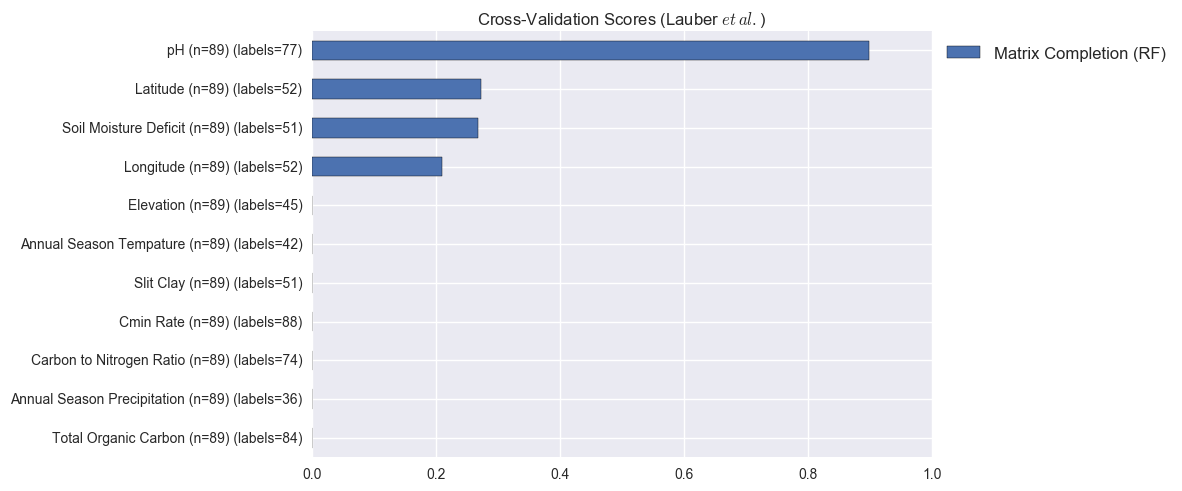

In [15]:
fig, (ax1) = plt.subplots(ncols=1, nrows=1)
soilsscores.columns=['Matrix Completion (RF)']
soilsscores.sort_values(['Matrix Completion (RF)'], ascending = [True], inplace = True)
#rename a few
soilsscores.plot(kind='barh',title='Cross-Validation Scores (Lauber $et \, al.$)',xlim=(0,1),ax=ax1)
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles[::-1], labels[::-1],loc=2,prop={'size':12}, bbox_to_anchor=(1.0, 1.0))
ax1.set_ylabel('')
plt.show()

 Supervised machine learning can also help extract important OTU (feature) patterns related to the mapping caterogies with the highest cross-validation scores.

 Now that we know pH is an important category we would like to find out what pattern of OTUs best explain this variation across samples. Here we plot the taxonomic pattern that the machine learning algorithm found to be most predictive at each pH level. 

 The taxonomy labels are the lowest classification assigned with the phylum in parenthesis. 

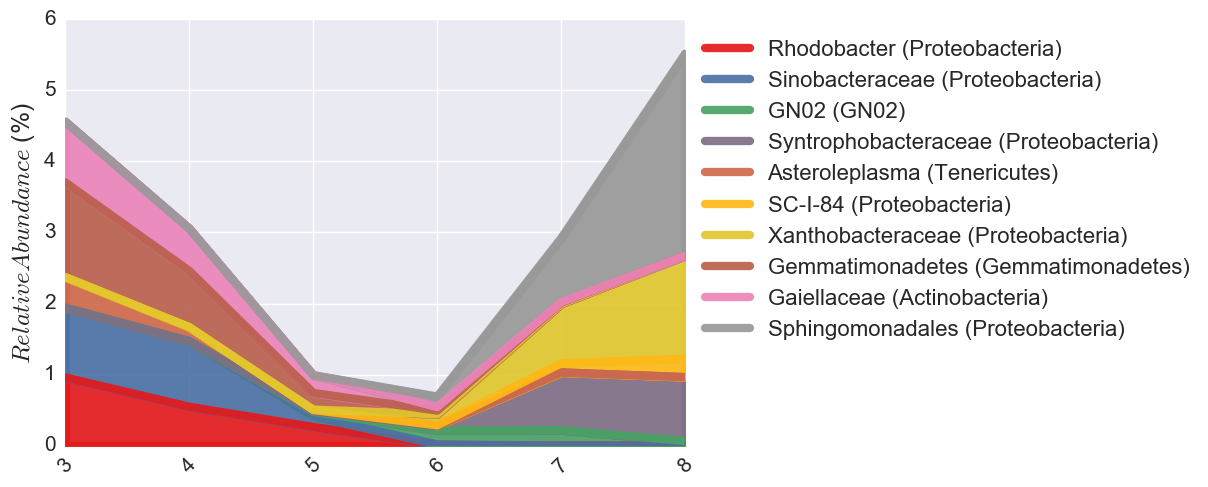

In [8]:
# get important features
n=10 #this will tell the command how many bacteria to plot
niche='pH' #this is a mapping file catagory you would like to plot
filter_names=['Unknown'] #this is a list of labels in the mapping you would like removed such as Unknown or Not available
# complete will determine if you do completion (iteration is the number of iterations for the completion)
sfotus,sfmappingdf=fetch.matchtable(otutabledf,mappingdf.T[~mappingdf.T[niche].isin(filter_names)].T)
important_otus=untangle.features_ml(sfotus,sfmappingdf.T,niche,complete=True,iteration=100)
#plot
fig=untangle.feature_vis(sfotus,sfmappingdf,list(important_otus.index[:n]),niche,taxnames)
plt.show()

Here we can clearly see the relative abundance of the OTUs changes across pH. For example we can say that a pH of 8 can be predicted as different from a pH of 7 by the OTUs Cyanobacteria, Xanthobacteraceae and Sphingomonadales of the phylum Cyanobacteria and Proteobacteria, respectively. 


Now that we have dense data (meaning almost no zeros) with matrix completion we can use previously restricted methods such as PCA. The motivation to using PCA is that we can extract biological knowledge about the axis in PCA that cannot be done in PCoA. We will take the centered log-ratio (clr) transform of the OTU table before performing PCA to account for compositionality. 

 Example: Identifying bacteria whose relative abundance changes along pH.

 Recovering information about features from PCA eigenvectors  

 Suppose we would like to see how the bacteria change along this first axis of pH since our machine learning identified that as the most predictive category from the metadata.

 The principal components are a linear combination of original features in N dimensional space.

 $ PC^{j} = \beta_{1}^{j}X_{1} +  \beta_{2}^{j}X_{2} + ... + \beta_{N}^{j}X_{N} $

 Where $\beta_{N}^{j}$ are weights and $X_{N}$ are the original variables.
 Therefore the coefficients are the transform of an identity matrix of shape X.
 Each column of the transformed coefficient matrix are the coefficients $\beta_{N}^{j}$ weight pertaining to each principal component $ PC^{j}$. 
 In other words we can examine the weights on each OTU or bacteria that best explain the variance of each axis in our PCA graph. 

 Now we can view the OTU gradient for pH through PCA

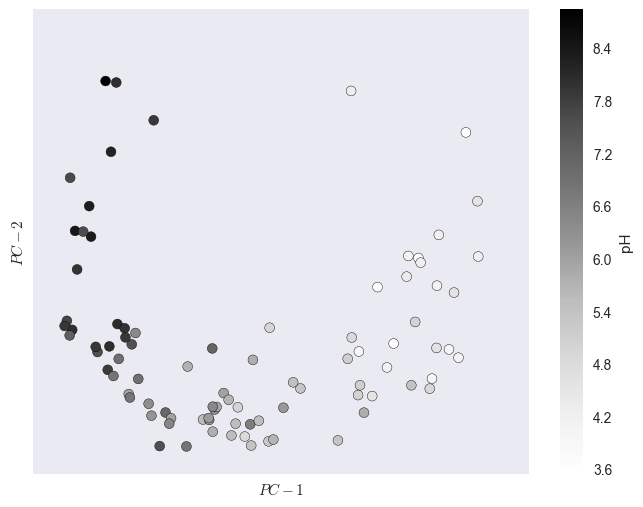

In [12]:
fig,OTUweightsPC1,OTUweightsPC2=untangle.reduce_plot(otutabledf,mappingdf,'pH',min_val=1e-4,iters=100)
plt.show()

 It looks like the data has a strong gradient along the axis $PC-1$ , but why? 

 We can find out using PCA because we can extract the variant bacteria along that axis. This tells us which taxa are driving the pH gradient in the data. Since the variance is along $PC-1$ we will use the data frame OTUweightsPC1

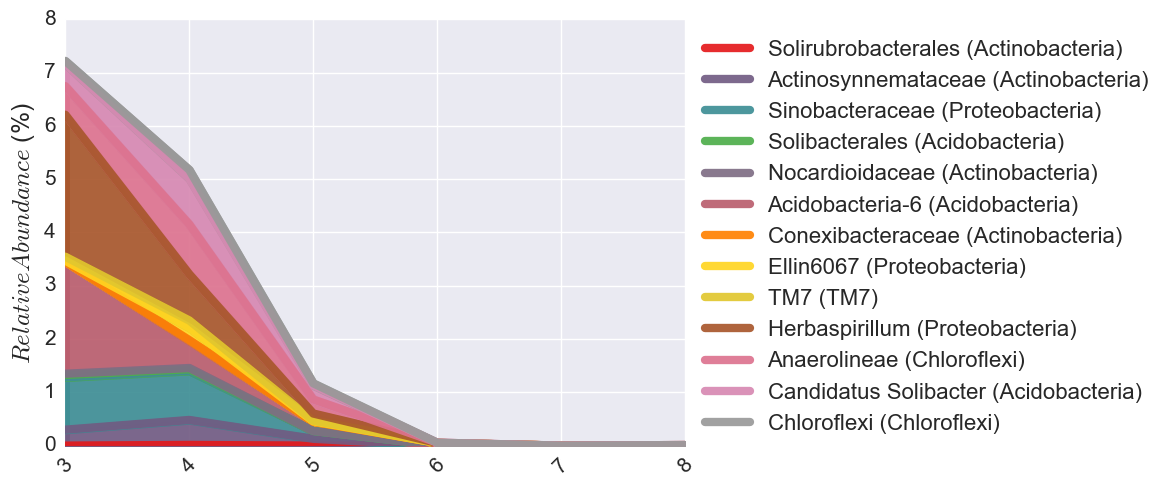

In [14]:
#plot 
#Note: we are using PC-2 here because the clusters are along that axis
n=13 #this will tell the command how many bacteria to plot
# taxanames is from the biom import,, it is a mapping file of the taxaonomy for each OTU
fig=untangle.feature_vis(otutabledf,mappingdf,list(OTUweightsPC1.index[:n]),niche,taxnames)
plt.show()

 The bacteria with the highest variance between pH clusters by multivariate weights make sense because they belong to the families Bradyrhizobiaceae, Sinobacteraceae and Acidobacteriaceae (this sentence doesn't make sense... also where did you get these taxa? not this plot). All of which have members that are described to grow at pH as low as 3 (B. elkanii (Jordan, 1982) and A. capsulatum (Hrash and Coates, 2011)), and pH 5 (S. flavus (Zhou et al., 2008)).

This matches the conclusions of the original paper and serves as a proof of concept.

http://aem.asm.org/content/75/15/5111.full

 [Next Example](https://github.com/cjm007/DEICODE/blob/master/Examples/sponge_biom.ipynb)